# Classifying Movie Genres




roughly following 
https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/, https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381

lyrics dataset: https://www.kaggle.com/datasets/albertsuarez/azlyrics

In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install --upgrade gensim

### imports

In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import nltk
import re
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from sklearn import utils

In [ ]:
#pd.set_option('display.max_colwidth', None)
#pd.set_option('display.max_rows', None)

### importing, cleaning, enriching, formatting data

data from https://www.cs.cmu.edu/~ark/personas/

In [ ]:
cmu_movie_metadata_path = '/content/drive/MyDrive/senior/nlp/nlp-final-project-team-21/cmu-movie-metadata/'
movie_metadata_file = os.path.join(cmu_movie_metadata_path, 'movie.metadata.tsv')
plot_summaries_file = os.path.join(cmu_movie_metadata_path, 'plot_summaries.txt')

getting movies and genre info into a dataframe

In [ ]:
def genre_string_to_list(s):
  s = s.strip('{}')
  if len(s.strip()) == 0:
    return []
  id_genre_pairs = s.split(',')
  genres = list(map(lambda pair : pair.split(':')[1].strip(' "'), id_genre_pairs))
  return genres

def parse_movie_genres():
  movie_df = pd.read_csv(movie_metadata_file, sep='\t', names=['id', 'genres'], usecols=[0,8])
  movie_df['genres'] = movie_df['genres'].map(genre_string_to_list)
  movie_df = movie_df[~(movie_df['genres'].str.len()==0)]
  return movie_df

In [ ]:
movies = parse_movie_genres()

In [ ]:
movies.loc[movies.astype(str).drop_duplicates().index]

,id,genres
0,975900,"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,"[Crime Fiction, Drama]"
3,9363483,"[Thriller, Erotic thriller, Psychological thri..."
4,261236,[Drama]
...,...,...
81736,35228177,[Drama]
81737,34980460,"[Biographical film, Drama, Documentary]"
81738,9971909,"[Satire, Comedy]"
81739,913762,"[Science Fiction, Japanese Movies, Adventure, ..."


In [ ]:
movies.head()

,id,genres
0,975900,"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,"[Crime Fiction, Drama]"
3,9363483,"[Thriller, Erotic thriller, Psychological thri..."
4,261236,[Drama]


In [ ]:
movies['genres'].explode().nunique()

363

In [ ]:
all_genres = list(movies['genres'].explode().unique())

In [ ]:
genre_df = movies['genres'].explode()
genre_freqs = genre_df.value_counts()
genre_freqs

Drama                   34007
Comedy                  16349
Romance Film            10234
Black-and-white          9094
Action                   8798
                        ...  
Romantic thriller           1
Comdedy                     1
C-Movie                     1
Silhouette animation        1
Homoeroticism               1
Name: genres, Length: 363, dtype: int64

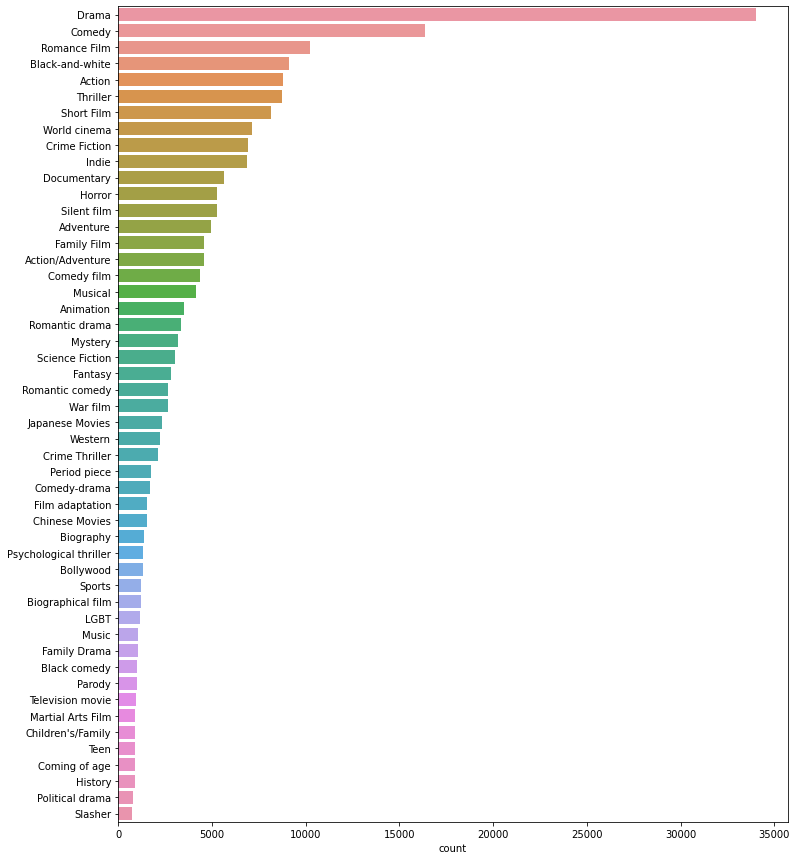

In [ ]:
def plot_freqs(data, n=False):
  top_n = data[:n] if n else data
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(x=top_n.values, y=top_n.index)
  ax.set(xlabel = 'count') 
  plt.show()
plot_freqs(genre_freqs, 50)

grouping these 363 genres into 41 broader categories. the grouping was done here, and is very much subjective/subject to change: https://docs.google.com/spreadsheets/d/1Vxqzn77h_lZQ6I-EKBUw7_cD5Lo44DmQmdcpLgrwYdw/edit?usp=sharing. Note that red entries have been ommitted due to nicheness or scarce representation in the data.

In [ ]:
genre_groups = {
    'Action': ['Action', 'Action/Adventure', 'War film', 'Martial Arts Film', 'Action Thrillers', 'Disaster', 'Action Comedy', 'Swashbuckler films', 'Combat Films', 'Auto racing', 'Sword and sorcery', 'Samurai cinema', 'Sword and sorcery films', 'Anti-war', 'Anti-war film', 'Biker Film', 'Outlaw biker film'],
    'Adaptation/Remake': ['Film adaptation', 'Remake'],
    'Adventure': ['Adventure', 'Action/Adventure', 'Buddy film', 'Road movie', 'Fantasy Adventure', 'Adventure Comedy', 'Costume Adventure', 'Jungle Film', 'Travel', 'Sci-Fi Adventure'],
    'Animation': ['Animation', 'Anime', 'Computer Animation', 'Stop motion', 'Animated cartoon', 'Animated Musical', 'Clay animation'],
    'Artistic': ['Art film', 'Experimental film', 'Avant-garde', 'Surrealism', 'Absurdism', 'Existentialism', 'Graphic & Applied Arts', 'Expressionism', 'World Cinema'],
    'B-Movie': ['B-movie', 'B-Western'],
    'Black-and-white': ['Black-and-white', 'Film noir'],
    'Chinese': ['Chinese Movies', 'Wuxia'],
    'Comedy': ['Comedy', 'Comedy film', 'Romantic comedy', 'Comedy-drama', 'Black comedy', 'Parody', 'Slapstick', 'Buddy film', 'Sex comedy', 'Crime Comedy', 'Screwball comedy', 'Comedy of manners', 'Horror Comedy', 'Musical comedy', 'Fantasy Comedy', 'Domestic Comedy', 'Comedy of Errors', 'Mockumentary', 'Action Comedy', 'Adventure Comedy', 'Workplace Comedy', 'Stand-up comedy', 'Comedy Thriller', 'Comedy Western', 'Tragicomedy', 'Stoner film', 'Heavenly Comedy', 'Comedy horror', 'Ealing Comedies', 'Courtroom Comedy', 'Humour'],
    'Commentary/Political': ['Culture & Society', 'Social issues', 'Propaganda film', 'Social problem film', 'Political satire', 'Political Drama', 'Political cinema', 'Political thriller', 'Political satire', 'Feminist Film', 'Dystopia', 'Absurdism', 'Media Satire', 'Gender Issues', 'Anti-war', 'Anti-war film', 'Existentialism', 'Kitchen sink realism', 'Satire'],
    'Crime': ['Crime Fiction', 'Crime Thriller', 'Film noir', 'Crime Drama', 'Spy', 'Gangster Film', 'Detective', 'Detective fiction', 'Crime Comedy', 'Heist', 'Prison', 'Caper story', 'Law & Crime', 'Whodunit', 'Neo-noir', 'Juvenile Delinquency Film', 'Glamorized Spy Film', 'Crime', 'Future noir', 'Master Criminal Films', 'Outlaw biker film', 'Women in prison films', 'Buddy cop', 'Prison film', 'Outlaw', 'Prison escape'],
    'Cult': ['Cult'],
    'Documentary/Informational': ['Documentary', 'Biography', 'Biographical film', 'Biopic [feature]', 'Docudrama', 'Rockumentary', 'Mockumentary', 'Film & Television History', 'Educational', 'Media Studies', 'Environmental Science', 'Film \u00e0 clef', 'Language & Literature', 'Essay Film', 'News', 'Anthropology', 'Inventions & Innovations', 'Mondo film', 'Archaeology', 'Journalism', 'Education', 'Historical Documentaries'],
    'Drama': ['Drama', 'Romantic drama', 'Comedy-drama', 'Family Drama', 'Political Drama', 'Melodrama', 'Film noir', 'Crime Drama', 'Costume drama', 'Docudrama', 'Historical drama', 'Courtroom Drama', 'Domestic Comedy', 'Musical Drama', 'Marriage Drama', 'Erotic Drama', 'Childhood Drama', 'Tragedy', 'Addiction Drama', 'Tragicomedy', 'Neo-noir', 'Interpersonal Relationships', 'Inspirational Drama', 'Fantasy Drama', 'Family & Personal Relationships', 'Legal drama'],
    'Ensemble': ['Ensemble Film'],
    'Epic': ['Epic', 'Historical Epic', 'Sword and Sandal'],
    'Family/Children': ['Family Film', 'Family Drama', "Children's/Family", "Children's", "Children's Fantasy", 'Family-Oriented Adventure', 'Childhood Drama', 'Fairy tale', "Children's Entertainment"],
    'Fantasy': ['Fantasy', "Children's Fantasy", 'Fantasy Comedy', 'Fantasy Adventure', 'Romantic fantasy', 'Fairy tale', 'Sword and sorcery', 'Sword and sorcery films', 'Mythological Fantasy', 'Fantasy Drama', 'Werewolf fiction'],
    'Filipino': ['Filipino Movies', 'Filipino'],
    'Health': ['Illnesses & Disabilities', 'Medical fiction', 'Albino bias', 'Health & Fitness'],
    'Historical': ['Period piece', 'History', 'Historical fiction', 'Historical drama', 'Historical Epic', 'Film & Television History', 'British Empire Film', 'World History', 'Cold War', 'Historical Documentaries'],
    'Holiday': ['Holiday Film', 'Christmas movie'],
    'Horror': ['Horror', 'Slasher', 'Creature Film', 'Zombie Film', 'Horror Comedy', 'Monster movie', 'Natural horror films', 'Monster', 'Supernatural', 'Haunted House Film', 'Costume Horror', 'Gross out', 'Gross-out film', 'Splatter film', 'Comedy horror', 'Road-Horror', 'Psycho-biddy', 'Demonic child', 'Psychological horror', 'Gothic Film'],
    'Indian': ['Bollywood', 'Tamil cinema', 'Tollywood', 'Bengali Cinema'],
    'Indie': ['Indie'],
    'Japanese': ['Japanese Movies', 'Samurai cinema', 'Tokusatsu'],
    'Music': ['Musical', 'Music', 'Concert film', 'Musical comedy', 'Rockumentary', 'Musical Drama', 'Hip hop movies', 'Punk rock', 'Animated Musical', 'Backstage Musical', 'Instrumental Music', 'Jukebox musical', 'Operetta', 'Film-Opera'],
    'Nature': ['Animal Picture', 'Nature', 'Natural horror films', 'Animals', 'Environmental Science', 'Natural disaster'],
    'Religion': ['Christian film', 'Religious Film', 'Hagiography'],
    'Romance': ['Romance Film', 'Romantic drama', 'Romantic comedy', 'Romantic fantasy'],
    'Sci-fi': ['Sci-Fi Horror', 'Science Fiction', 'Alien Film', 'Time travel', 'Apocalyptic and post-apocalyptic fiction', 'Doomsday film', 'Steampunk', 'Sci-Fi Adventure', 'Future noir', 'Space western', 'Science fiction Western', 'Alien invasion', 'Cyberpunk', 'Sci-Fi Thriller', 'Sci Fi Pictures original films', 'Space opera'],
    'Short Film': ['Short Film'],
    'Silent Film': ['Silent film'],
    'Sports': ['Sports', 'Boxing', 'Extreme Sports', 'Dance', 'Horse racing', 'Baseball'],
    'Superhero': ['Superhero movie', 'Superhero'],
    'Suspense/Thriller': ['Thriller', 'Mystery', 'Crime Thriller', 'Psychological thriller', 'Suspense', 'Action Thrillers', 'Political thriller', 'Erotic thriller', 'Chase Movie', 'Comedy Thriller', 'Escape Film', 'Slasher', 'Giallo', 'Sci-Fi Thriller'],
    'Teen': ['Teen', 'Coming of age', 'Juvenile Delinquency Film', 'Beach Film', 'Coming-of-age film'],
    'Television Movie': ['Television movie'],
    'Themes of Sex': ['LGBT', 'Gay Themed', 'Sexploitation', 'Sex comedy', 'Pornographic movie', 'Erotica', 'Gay', 'Gay Interest', 'Adult', 'Erotic thriller', 'Erotic Drama', 'Gender Issues', 'Gay pornography', 'Softcore Porn', 'Pornography', 'Hardcore pornography'],
    'Western': ['Western', 'Spaghetti Western', 'Comedy Western', 'Revisionist Western', 'B-Western', 'Indian Western', 'Northern', 'Epic Western', 'Acid western'],
}

In [ ]:
#reversing above dictionary to convert genres in our df to new ones
genre_conversion_dict = {}
for k, v in genre_groups.items():
  for x in v:
    genre_conversion_dict.setdefault(x,[]).append(k)

In [ ]:
def broaden_genres(genre_list):
  new_genres = set()
  for old_genre in genre_list:
    if old_genre in genre_conversion_dict:
      new_genres.update(genre_conversion_dict[old_genre])
  return list(new_genres)

In [ ]:
movies['genres'] = movies['genres'].map(lambda genre_list: broaden_genres(genre_list))
movies.shape

(79447, 2)

In [ ]:
#removing movies with empty new genre lists
movies = movies[movies['genres'].map(lambda l: len(l)) > 0]
movies.shape

(79315, 2)

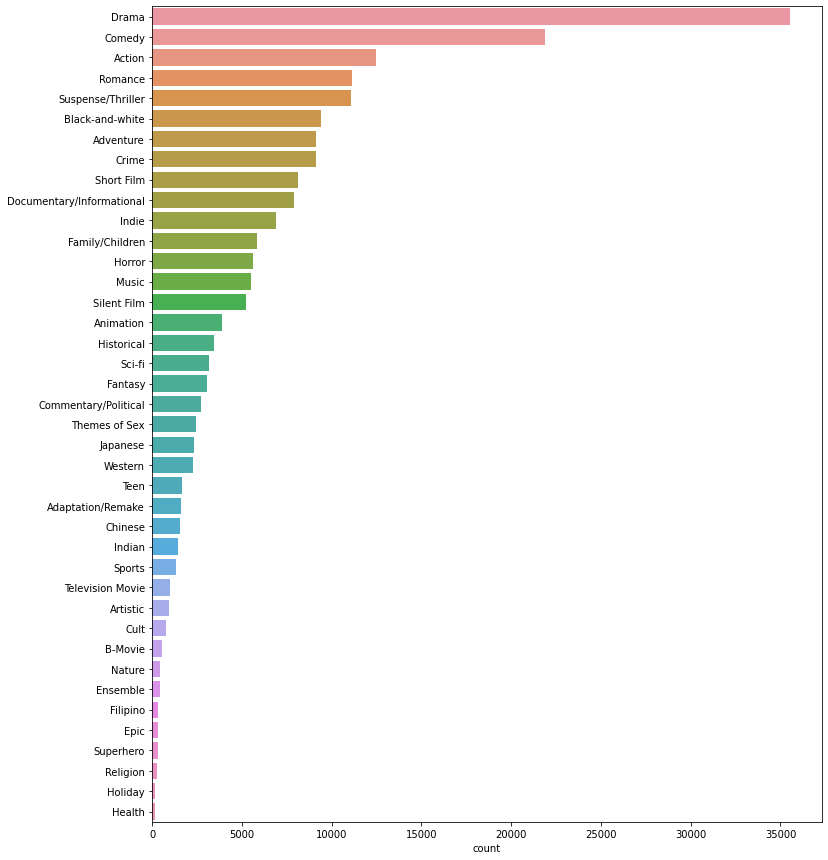

In [ ]:
new_genre_freqs = movies['genres'].explode().value_counts()
plot_freqs(new_genre_freqs)

clustering genres based on correlation

In [ ]:
genres_exploded = movies['genres'].explode()
genres_onehot = pd.crosstab(genres_exploded.index, genres_exploded)
corr = genres_onehot.corr()
corr.style.background_gradient(cmap='coolwarm')

genres,Action,Adaptation/Remake,Adventure,Animation,Artistic,B-Movie,Black-and-white,Chinese,Comedy,Commentary/Political,Crime,Cult,Documentary/Informational,Drama,Ensemble,Epic,Family/Children,Fantasy,Filipino,Health,Historical,Holiday,Horror,Indian,Indie,Japanese,Music,Nature,Religion,Romance,Sci-fi,Short Film,Silent Film,Sports,Superhero,Suspense/Thriller,Teen,Television Movie,Themes of Sex,Western
genres,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Action,1.000000,0.027810,0.493598,-0.034996,-0.015641,-0.000988,-0.058227,0.109884,-0.097445,0.014741,0.142260,-0.002947,-0.062702,-0.028291,-0.014799,0.066050,-0.051874,0.039547,-0.002983,-0.008699,0.063401,-0.016337,-0.038257,0.007573,-0.054208,0.025813,-0.073580,0.007362,-0.003617,-0.052580,0.098662,-0.118874,-0.087655,0.005613,0.109475,0.162963,-0.033901,0.014245,-0.051166,0.159958
Adaptation/Remake,0.027810,1.000000,0.038579,-0.028552,-0.003421,-0.008899,-0.002923,-0.015112,-0.025984,0.025099,0.045582,0.014267,-0.020483,0.139029,0.019886,0.049316,0.017684,0.012440,-0.009568,0.007388,0.141218,0.001002,0.010654,-0.018994,0.024292,-0.017670,-0.025552,0.016837,0.020792,0.073919,0.018714,-0.047567,-0.034062,0.005600,-0.000327,0.061396,0.047043,0.100009,0.028687,0.003344
Adventure,0.493598,0.038579,1.000000,0.041340,-0.002565,0.001030,-0.035438,0.081122,-0.012353,-0.007039,0.099232,0.025135,-0.083808,-0.062390,-0.008924,0.059309,0.089152,0.155390,-0.007749,-0.006575,0.022789,-0.001390,-0.026706,-0.017820,-0.018914,0.027996,-0.048101,0.041868,0.007557,-0.048018,0.133184,-0.105762,-0.060083,0.001202,0.126242,0.138226,0.004467,0.026753,-0.033156,0.176320
Animation,-0.034996,-0.028552,0.041340,1.000000,-0.010820,-0.013454,-0.074753,-0.019649,0.054650,-0.027787,-0.072882,-0.007287,-0.063707,-0.167599,-0.016416,-0.007726,0.345333,0.168365,-0.014173,-0.010230,-0.038811,0.036079,-0.037590,-0.029633,-0.056310,0.088948,0.009828,-0.005297,-0.004286,-0.072459,0.065525,0.286677,-0.053337,-0.018165,0.034908,-0.069665,-0.022800,-0.016766,-0.029537,-0.027659
Artistic,-0.015641,-0.003421,-0.002565,-0.010820,1.000000,-0.005019,0.002268,-0.005300,-0.002467,0.114197,-0.004757,0.034681,0.007903,0.046740,0.010238,0.003504,-0.010463,0.018600,-0.007274,0.005407,0.014988,-0.005093,-0.003035,0.031136,0.028173,0.049207,0.007315,-0.005413,0.002235,0.003672,0.008134,-0.002143,-0.013249,-0.007922,-0.004941,-0.008447,0.000874,-0.012205,0.031787,-0.014057
B-Movie,-0.000988,-0.008899,0.001030,-0.013454,-0.005019,1.000000,-0.007942,-0.011827,-0.010249,-0.007453,-0.019354,0.091084,-0.025414,-0.067461,-0.006368,-0.005513,-0.023727,-0.008183,-0.003291,-0.003789,-0.017143,-0.000647,0.265358,-0.011462,0.021802,-0.011037,-0.021708,0.068419,-0.004696,-0.031771,0.078109,-0.026424,-0.018723,-0.010952,0.014272,0.055648,0.044334,-0.005238,-0.005322,0.045882
Black-and-white,-0.058227,-0.002923,-0.035438,-0.074753,0.002268,-0.007942,1.000000,-0.042340,0.014737,-0.020810,0.027661,-0.023262,-0.073077,-0.023614,-0.016435,0.001576,-0.045811,-0.044102,-0.022004,-0.003561,-0.036774,-0.012857,-0.056394,-0.045990,0.205341,-0.017909,-0.031033,-0.015595,-0.011418,-0.036383,-0.037092,0.185551,0.397904,-0.031717,-0.002719,-0.046591,-0.045306,-0.039462,-0.051999,0.070786
Chinese,0.109884,-0.015112,0.081122,-0.019649,-0.005300,-0.011827,-0.042340,1.000000,-0.017764,-0.015364,-0.003983,-0.011021,-0.029109,-0.019856,-0.003396,0.006144,-0.026129,0.006466,-0.005198,-0.006348,0.006820,-0.006543,-0.005770,-0.018520,-0.031446,-0.000146,-0.029362,-0.009665,-0.006228,0.004933,-0.015523,-0.039781,-0.032700,-0.010508,0.013342,-0.001247,-0.009278,-0.015679,-0.001233,-0.021580
Comedy,-0.097445,-0.025984,-0.012353,0.054650,-0.002467,-0.010249,0.014737,-0.017764,1.000000,0.032917,-0.062358,0.042518,-0.158422,-0.181263,0.062557,-0.037030,0.094253,0.031127,-0.000835,-0.014664,-0.078138,0.021198,-0.075963,-0.020127,0.081528,-0.065239,0.041132,-0.004166,-0.004611,0.131515,-0.032986,0.060447,-0.015616,0.010489,0.000284,-0.138940,0.061943,-0.026929,0.029647,-0.0545

In [ ]:
corr.loc[:,:] =  np.tril(corr, k=-1)
corr_threshold = 0.2

already_in = set()
clusters = []
for col in corr:
    correlated = corr[col][corr[col] >= corr_threshold].index.tolist()
    if correlated and col not in already_in:
        already_in.update(set(correlated))
        correlated.append(col)
        clusters.append(correlated)

len(clusters)

7

In [ ]:
clusters

[['Adventure', 'Action'],
 ['Family/Children', 'Short Film', 'Animation'],
 ['Horror', 'B-Movie'],
 ['Indie', 'Silent Film', 'Black-and-white'],
 ['Suspense/Thriller', 'Crime'],
 ['Horror', 'Cult'],
 ['Music', 'Indian']]

grabbing plot summaries

In [ ]:
def parse_plot_summaries():
  plot_summaries = dict()
  with open(plot_summaries_file) as f:
    for line in f:
      movie_id, summary = line.split('\t')
      movie_id = int(movie_id)
      plot_summaries[movie_id] = summary
  return plot_summaries

In [ ]:
plot_summaries = parse_plot_summaries()

merging movie genre dataframe with plot summaries on the id (inner join; entries reduced from ~82k to ~42k since ~39k movies are not provided summaries)

In [ ]:
movies['summary'] = movies['id'].map(plot_summaries)
movies = movies[movies['summary'].notna()]
movies.head()

,id,genres,summary
0,975900,"[Horror, Adventure, Suspense/Thriller, Action,...","Set in the second half of the 22nd century, th..."
3,9363483,"[Themes of Sex, Suspense/Thriller]",A series of murders of rich young women throug...
4,261236,[Drama],"Eva, an upper class housewife, becomes frustra..."
6,18998739,"[Family/Children, Fantasy, Adventure]","Every hundred years, the evil Morgana returns..."
12,6631279,"[Drama, Comedy, Ensemble, Romance]","Adam, a San Francisco-based artist who works a..."


processing summaries: normalization, stopword removal, lemmatization. converts summary string into list of cleaned tokens

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
#ps = PorterStemmer()
from nltk.stem import WordNetLemmatizer
lm = WordNetLemmatizer()

stopword_list = stopwords.words('english')

def clean_summary(summary):
  summary = summary.lower()
  summary = re.sub(r'(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?', '', summary)
  summary = [lm.lemmatize(word) for word in summary.split() if word not in stopword_list]
  return summary

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
movies['summary'] = movies['summary'].progress_map(clean_summary)
movies.head()

progress-bar: 100%|██████████| 41718/41718 [01:47<00:00, 388.34it/s]


,id,genres,summary
0,975900,"[Horror, Adventure, Suspense/Thriller, Action,...","[set, second, half, 22nd, century, film, depic..."
3,9363483,"[Themes of Sex, Suspense/Thriller]","[series, murder, rich, young, woman, throughou..."
4,261236,[Drama],"[eva, upper, class, housewife, becomes, frustr..."
6,18998739,"[Family/Children, Fantasy, Adventure]","[every, hundred, year, evil, morgana, return, ..."
12,6631279,"[Drama, Comedy, Ensemble, Romance]","[adam, san, franciscobased, artist, work, cab,..."


In [ ]:
#total number of words...
movies['summary'].apply(lambda x: len(x)).sum()

7071561

In [ ]:
def word_freq(series, max_words = 50): 
  all_words = []
  for word_list in series:
    all_words.extend(word_list)
  fd = nltk.FreqDist(all_words)
  top_n = pd.Series(dict(fd.most_common(max_words)))

  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(x=top_n.values, y=top_n.index) 
  ax.set(xlabel='count', ylabel='word') 
  plt.show()

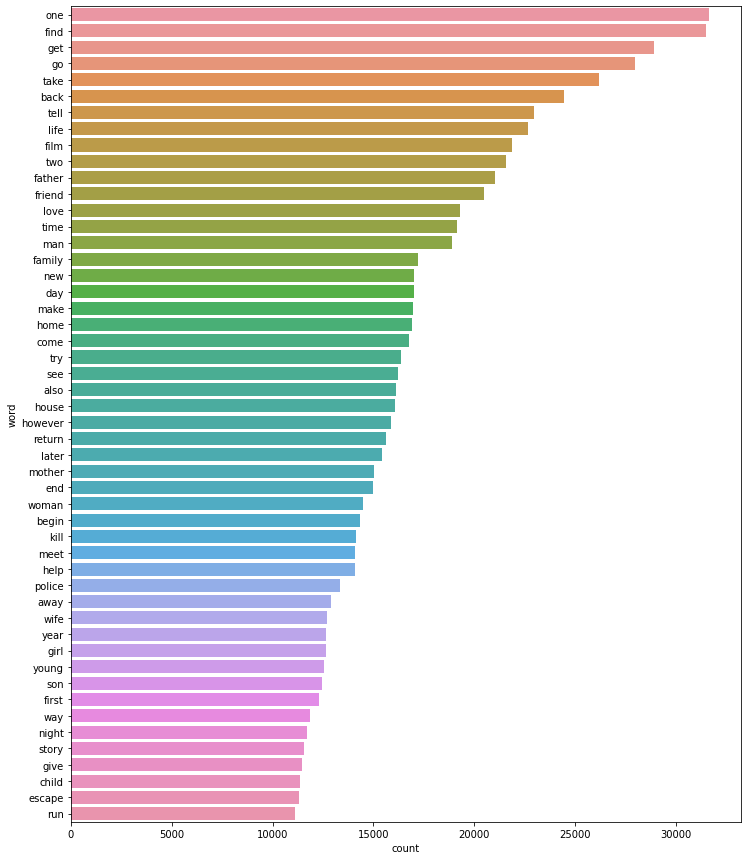

In [ ]:
word_freq(movies['summary'], 50)

train-test split

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(movies, test_size=0.3)

summaries --> TaggedDocuments
https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4#:~:text=Doc2vec%20is%20an%20NLP%20tool,advisable%20to%20understand%20word2vec%20approach.

In [ ]:
#from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [ ]:
train_tagged = train.apply(lambda movie: TaggedDocument(words=movie['summary'], tags=[*movie['genres']]), axis=1)
test_tagged = test.apply(lambda movie: TaggedDocument(words=movie['summary'], tags=[*movie['genres']]), axis=1)
#, *movie['genres']

In [ ]:
train_tagged.values[0]

TaggedDocument(words=['lotte', 'mrz', 'hired', 'secretary', 'insurance', 'company', 'ugly', 'introducing', 'accountant', 'personnel', 'manager', 'say', 'hope', 'finally', 'able', 'work', 'peace', 'men', 'harass', 'conspire', 'lure', 'compromising', 'position', 'one', 'fritz', 'mahldorf', 'pretend', 'find', 'attractive', 'manager', 'discovers', 'embrace', 'fritz', 'fire', 'selfabsorbed', 'fritz', 'showing', 'remorse', 'unusual', 'arranges', 'rehired', 'assistant', 'director', 'mnckeberg', 'lotte', 'fallen', 'make', 'date', 'flat', 'director', 'girlfriend', 'lydia', 'soon', 'arrives', 'lotte', 'jealous', 'director', 'farcical', 'misunderstanding', 'ensue', 'including', 'discovery', 'lydia', 'fur', 'coat', 'fancydress', 'ball', 'director', 'villa', 'lotte', 'dress', 'pirate', 'lotte', 'undergoes', 'complete', 'makeover', 'beauty', 'parlour', 'haircut', 'perm', 'facialmdashand', 'transformed', 'attractive', 'flapper', 'fritz', 'fall', 'love', 'love', 'triumph', 'although', 'remains', 'flat

building and training doc2vec model

In [ ]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [ ]:
d2v_model = Doc2Vec(dm=0, vector_size=300, min_count=15, workers=cores)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 29202/29202 [00:00<00:00, 1324159.07it/s]


In [ ]:
class EpochLogger():
    '''Callback to log information about training'''
    def __init__(self, total_epochs):
        self.epoch = 1
        self.total_epochs = total_epochs

    def on_train_begin(self, model):
        print("Training begun...")

    def on_epoch_begin(self, model):
        pass
    def on_batch_begin(self,model):
        pass
    def on_batch_end(self,model):
        pass
    def on_epoch_end(self, model):
        print("Epoch {} done: {}%".format(self.epoch, round(self.epoch*100/self.total_epochs, 2)))
        self.epoch += 1
    
    def on_train_end(self, model):
        print("Training finished.")

In [ ]:
max_epochs = 30
epoch_logger = EpochLogger(max_epochs)
d2v_model.train(utils.shuffle(train_tagged.values), total_examples=len(train_tagged.values), epochs=max_epochs, callbacks=[epoch_logger])

Training begun...
Epoch 1 done: 3.33%
Epoch 2 done: 6.67%
Epoch 3 done: 10.0%
Epoch 4 done: 13.33%
Epoch 5 done: 16.67%
Epoch 6 done: 20.0%
Epoch 7 done: 23.33%
Epoch 8 done: 26.67%
Epoch 9 done: 30.0%
Epoch 10 done: 33.33%
Epoch 11 done: 36.67%
Epoch 12 done: 40.0%
Epoch 13 done: 43.33%
Epoch 14 done: 46.67%
Epoch 15 done: 50.0%
Epoch 16 done: 53.33%
Epoch 17 done: 56.67%
Epoch 18 done: 60.0%
Epoch 19 done: 63.33%
Epoch 20 done: 66.67%
Epoch 21 done: 70.0%
Epoch 22 done: 73.33%
Epoch 23 done: 76.67%
Epoch 24 done: 80.0%
Epoch 25 done: 83.33%
Epoch 26 done: 86.67%
Epoch 27 done: 90.0%
Epoch 28 done: 93.33%
Epoch 29 done: 96.67%
Epoch 30 done: 100.0%
Training finished.


In [ ]:
d2v_model.save('d2v.model')

generating vectors for our ML model

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(movies['genres'])

MultiLabelBinarizer()

In [ ]:
def generate_vectors(model, tagged_summaries):
  summaries = tagged_summaries.values
  X, y = zip(*[(model.infer_vector(summary.words), mlb.transform([summary.tags])[0]) for summary in tqdm(summaries, position=0, leave=True)])
  return np.array(X), np.array(y)

In [ ]:
X_train, y_train = generate_vectors(d2v_model, train_tagged)
X_test, y_test = generate_vectors(d2v_model, test_tagged)

100%|██████████| 12516/12516 [03:14<00:00, 64.32it/s]


training our classification model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

In [ ]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [ ]:
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

predict on test set, evaluate results

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
y_test = np.array(y_test)

In [ ]:
print(y_test)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [ ]:
print('Testing F1 score (weighted): {}'.format(f1_score(y_test, y_pred, average='weighted')))
print('Testing F1 score (micro): {}'.format(f1_score(y_test, y_pred, average='micro')))

Testing F1 score (weighted): 0.4888961496245949
Testing F1 score (micro): 0.5060027421997794


In [ ]:
y_pred_prob = clf.predict_proba(X_test)

In [ ]:
t = 0.25 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [ ]:
print('Testing F1 score (weighted): {}'.format(f1_score(y_test, y_pred_new, average='weighted')))
print('Testing F1 score (micro): {}'.format(f1_score(y_test, y_pred_new, average='micro')))

Testing F1 score (weighted): 0.5357064701600464
Testing F1 score (micro): 0.5469061876247504


In [ ]:
test[:10]

,id,genres,summary
21878,13701844,"[Comedy, Short Film, Black-and-white]","[trio, employed, handyman, recording, studio, ..."
7509,35685303,[Comedy],"[recent, college, graduate, belief, shes, dest..."
61041,19992131,"[Suspense/Thriller, Drama, Horror]","[plot, middle, school, teacher, anna, taylor, ..."
25656,14740242,"[Comedy, Short Film, Black-and-white]","[stooge, janitorsturneddelegates, recruited, s..."
41607,76641,"[Comedy, Romance, Black-and-white]","[sam, craig, te, harding, journalist, new, yor..."
5804,9176428,"[Suspense/Thriller, Action, Adventure, Crime]","[u, agent, sent, communist, china, order, retr..."
16801,30745592,[Comedy],"[story, revolves, around, film, unit, help, tw..."
20686,7148350,"[Family/Children, Indie, Drama, Adaptation/Rem...","[film, begin, introducing, kellyanne, williams..."
25077,2061620,"[Suspense/Thriller, Commentary/Political, Come...","[wood, outside, small, affluent, town, cherry,..."
54678,3154528,"[Comedy, Romance]","[1995, chris, brander, obese, curlyhaired, hig..."


In [ ]:
mlb.inverse_transform(y_pred_new)[:10]

[('Black-and-white', 'Comedy', 'Music', 'Short Film'),
 ('Comedy', 'Drama', 'Romance'),
 ('Adaptation/Remake',
  'Drama',
  'Fantasy',
  'Horror',
  'Indie',
  'Suspense/Thriller'),
 ('Black-and-white', 'Comedy'),
 ('Comedy', 'Drama'),
 ('Action', 'Adventure', 'Chinese', 'Sci-fi', 'Suspense/Thriller'),
 ('Drama',),
 ('Documentary/Informational', 'Drama'),
 ('Drama', 'Horror', 'Indie', 'Japanese', 'Suspense/Thriller', 'Teen'),
 ('Comedy', 'Drama', 'Romance')]

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
confusion_matrices = multilabel_confusion_matrix(y_test, y_pred_new)
len(confusion_matrices)

40

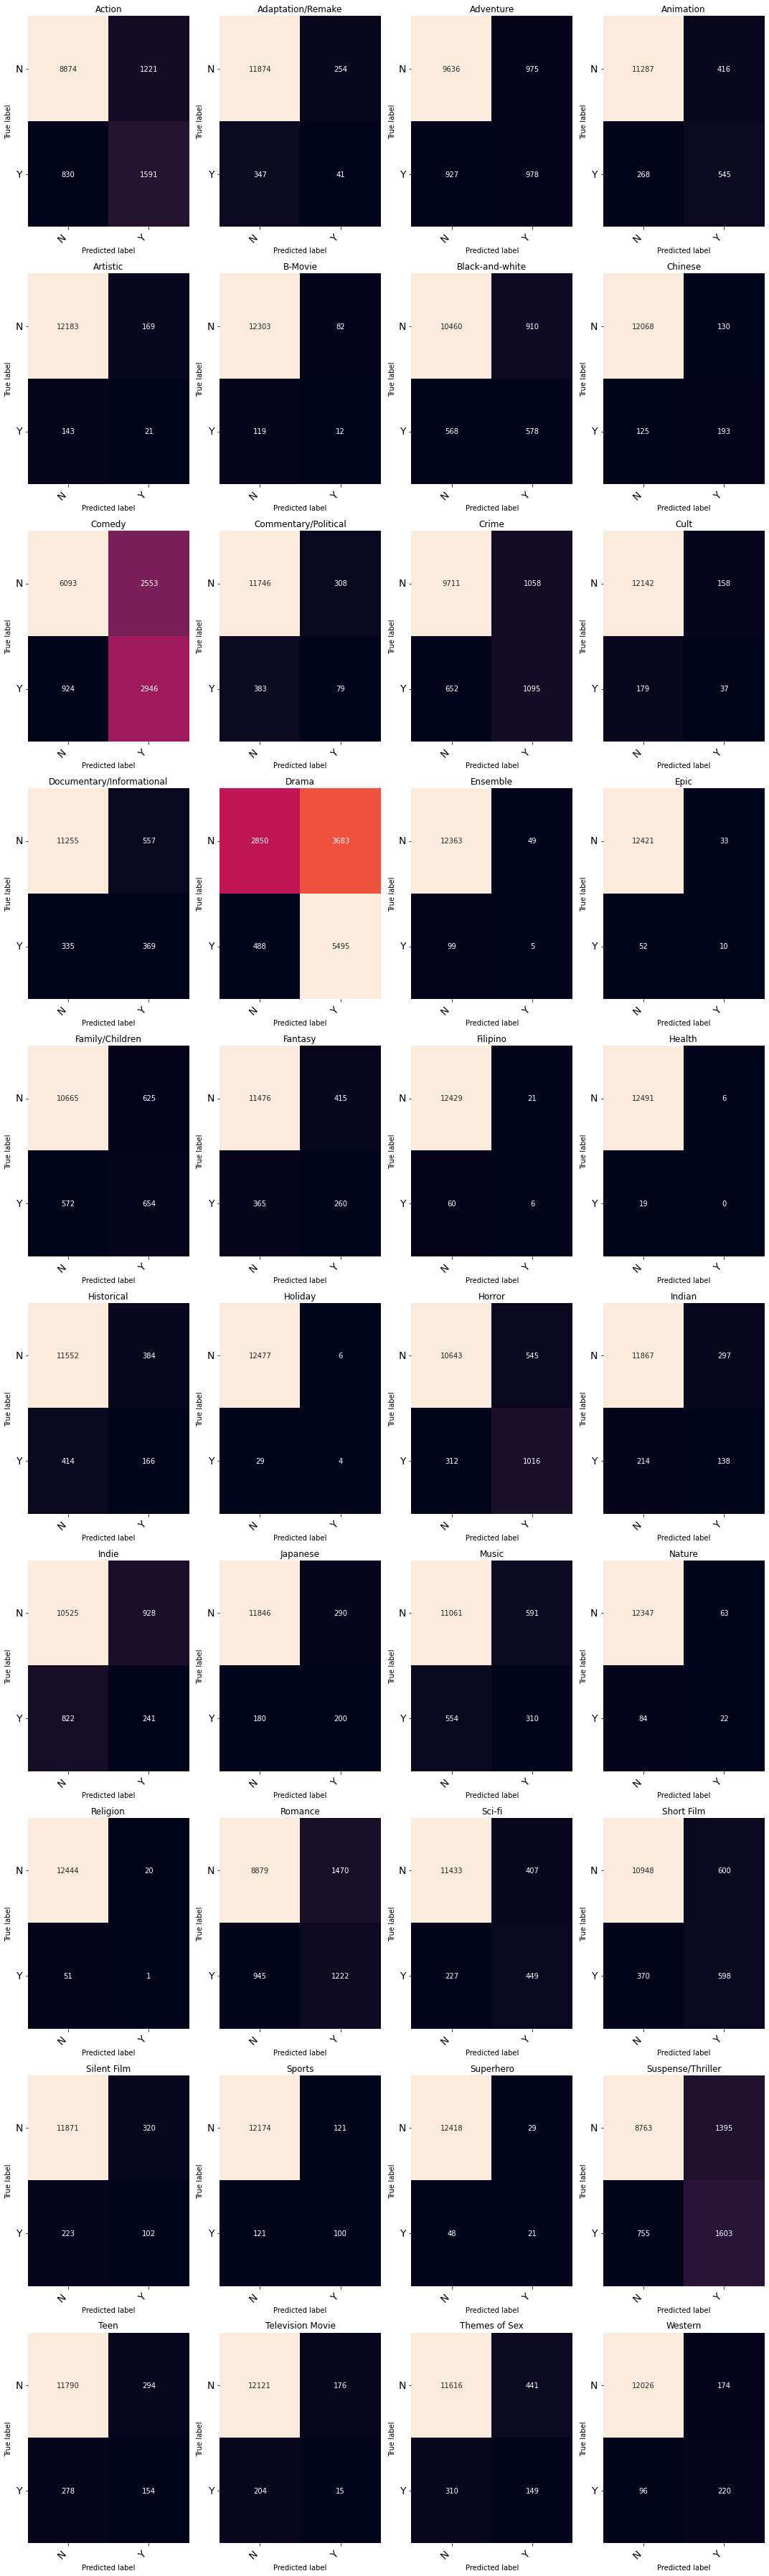

In [ ]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

fig, ax = plt.subplots(nrows=10, ncols=4, figsize=(15,50))
    
for axes, cfs_matrix, label in zip(ax.flatten(), confusion_matrices, sorted(genre_groups.keys())):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

inference function!

In [ ]:
from operator import invert
# add threshold (0.25) to inference
def infer_genres(summary):
  processed_summary = clean_summary(summary)
  vec = d2v_model.infer_vector(processed_summary)
  pred = clf.predict_proba([vec])
  genreandprob = list(zip(mlb.classes_, pred[0]))
  genreandprob.sort(key=lambda currgenre: currgenre[1], reverse = True)
  print(genreandprob)

  # do stuff

In [ ]:
infer_genres('scary movie lots of dying and murder gore left and right this movie is sure to scare you witless')

[('Suspense/Thriller', 0.2561550574008002), ('Drama', 0.23597390667577361), ('Horror', 0.2304863674243183), ('Short Film', 0.1291637765463819), ('Comedy', 0.09835740358813028), ('Crime', 0.09740324153709862), ('Action', 0.0687871847298558), ('Black-and-white', 0.06382631446802331), ('Silent Film', 0.05014301047983637), ('Adventure', 0.03546961557324055), ('Indie', 0.033004832551264934), ('Music', 0.023140943705573465), ('Sci-fi', 0.022842447009751684), ('Documentary/Informational', 0.02210105127152756), ('Animation', 0.020984757241770968), ('Family/Children', 0.0153169229202191), ('Romance', 0.01412823631655752), ('Western', 0.012571507114751466), ('Television Movie', 0.012488732648917887), ('Japanese', 0.012481461038719627), ('Fantasy', 0.007616229204821349), ('Themes of Sex', 0.007344125553619918), ('B-Movie', 0.0058965609253017305), ('Adaptation/Remake', 0.005762164238468911), ('Teen', 0.004818878925500867), ('Historical', 0.0035591342194723104), ('Indian', 0.002320526318683566), ('

*todo*: cross-validation

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
forest_clf = BalancedRandomForestClassifier(n_estimators = 100, n_jobs=-1)
# multiout_clf = MultiOutputClassifier(forest_clf,n_jobs=-1)
multiout_ovr_clf =OneVsRestClassifier(forest_clf)
multiout_ovr_clf.fit(X_train, y_train)
ypred = multiout_ovr_clf.predict(X_test)
print(accuracy_score(y_test, ypred))

0.0029562160434643656


In [ ]:
print('Testing F1 score (weighted): {}'.format(f1_score(y_test, ypred, average='weighted')))
print('Testing F1 score (micro): {}'.format(f1_score(y_test, ypred, average='micro')))

Testing F1 score (weighted): 0.4747019230983734
Testing F1 score (micro): 0.3856748895017188


In [ ]:
for i in range(len(ypred)):
  print(np.where(ypred[i]!=0))

Streaming output truncated to the last 5000 lines.
(array([ 6,  8, 29, 31, 32]),)
(array([ 0,  1,  2,  3,  8, 15, 16, 17, 22, 25, 27, 30, 34]),)
(array([ 1,  3,  6,  8, 11, 16, 24, 29, 31, 33, 36]),)
(array([ 0,  2,  6, 10, 13, 15, 20, 32, 35, 39]),)
(array([10, 13, 24, 35, 37]),)
(array([ 0,  1,  2,  4,  9, 10, 13, 14, 15, 20, 22, 24, 25, 35]),)
(array([ 8, 14, 17, 22, 24, 29, 37, 38]),)
(array([ 1,  4,  8,  9, 11, 13, 16, 20, 26, 28, 33, 36, 37]),)
(array([ 6,  8, 13, 26, 29, 32, 33, 38]),)
(array([ 0,  2,  9, 13, 15, 20, 29, 37]),)
(array([ 1,  2,  4,  7,  9, 11, 17, 18, 22, 24, 25, 35, 36]),)
(array([ 0,  1,  2,  8,  9, 10, 12, 19, 20, 27, 28, 30]),)
(array([ 0,  2,  3, 10, 11, 22, 24, 27, 30, 35]),)
(array([ 1,  6,  8, 13, 20, 28, 34, 39]),)
(array([ 0,  2,  9, 12, 13, 15, 19, 20]),)
(array([ 6,  8, 29, 32, 36, 37]),)
(array([ 0,  2, 13, 23, 26, 35]),)
(array([ 0,  1,  2, 10, 13, 25, 29, 33, 35, 39]),)
(array([ 0,  1,  2,  6,  9, 13, 16]),)
(array([ 6, 10, 31]),)
(array([ 6,  8, 3

In [ ]:
mlb.classes_[13]

In [ ]:
from sklearn.svm import SVC
svc_clf = SVC()
ovr_svc_clf = OneVsRestClassifier(svc_clf)
ovr_svc_clf.fit(X_train, y_train)
ypred = ovr_svc_clf.predict(X_test)
print(accuracy_score(y_test, ypred))

0.11736976669862575


In [ ]:
print('Testing F1 score (weighted): {}'.format(f1_score(y_test, ypred, average='weighted')))
print('Testing F1 score (micro): {}'.format(f1_score(y_test, ypred, average='micro')))

Testing F1 score (weighted): 0.47278700939027957
Testing F1 score (micro): 0.5098331184513973
